## Survival trees
In reality, predicting the risk of churning is more useful than a classification task, as the organization can often proactively engage with high-risk users to improve retention.

I'll try to train a survival random forest


In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

In [20]:
df = pd.read_csv('dataset_encoded_features.csv')
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [21]:
# Recode y (event) to bool: "is_churned" = 0 - False, 'is_churned' = 1 - True, event has happened

y = pd.concat([df['is_churned'].astype(bool), df['sessions'].astype(float)],axis=1)
dtype = [('event', bool), ('time', float)]
y = np.array(list(zip(df['is_churned'].astype(bool), df['sessions'].astype(float))),dtype=dtype)
X = df.drop(columns=['is_churned', 'sessions', 'ID', 'device_code', 'drives', 'total_sessions'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=45)


In [22]:
random_state = 20
rsf = RandomSurvivalForest(
    n_estimators=100, min_samples_split=15, min_samples_leaf=10, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=15, n_jobs=-1,
                     random_state=20)

In [24]:
event_indicator = y_val['event']
event_time = y_val['time']
prediction = rsf.predict(X_val)
result = concordance_index_censored(event_indicator, event_time, prediction)
print(result)

(0.8627411594633836, 545475, 86783, 0, 5445)


We see that the concordance index value is 0.86. that is pretty high result.

In [32]:
prediction = rsf.predict(X_train)
result_df = pd.DataFrame({'event_time': y_train['time'], 'prediction': prediction, 'is_churned': y_train['event']})

Now let's train a logistic regression to identify a decision boundary -- a risk value to use to decide if a user churned or not

In [33]:
X = prediction.reshape(-1, 1)
clf = LogisticRegression().fit(X, y_train['event'])

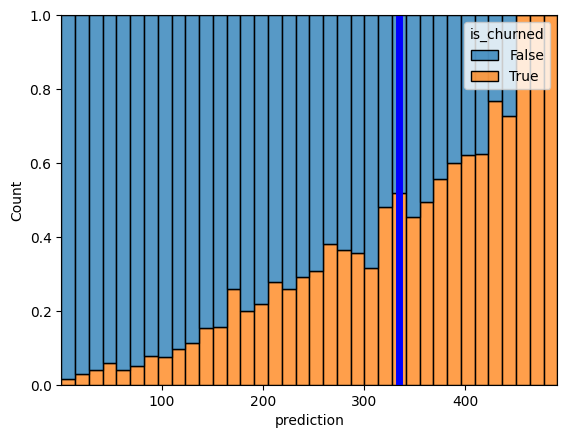

In [34]:
x_values = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
coef = clf.coef_[0]
intercept = clf.intercept_[0]
decision_boundary = -intercept/coef
fig,ax= plt.subplots(1)
sns.histplot(result_df, hue='is_churned', x='prediction', multiple='fill', ax=ax)
ax.axvline(decision_boundary,linewidth=5, color = 'b')

In [28]:
perm_import = permutation_importance(rsf, X_val, y_val, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
      k: perm_import[k]
      for k in (
          "importances_mean",
          "importances_std",
          )
    },
    index=X_val.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
km_per_drive,0.076369,0.004161
drives_per_driving_day,0.064886,0.001792
sessions_per_activity_day,0.062032,0.001475
activity_days,0.061357,0.007326
driving_days,0.014924,0.004926
driven_km_drives,0.013859,0.002128
n_days_after_onboarding,0.006188,0.002148
total_navigations_fav1,0.001962,0.000961
total_navigations_fav2,0.000096,0.000649
duration_minutes_drives,-0.002208,0.000665


from matplotlib import pyplot as plt
_df_0['importances_mean'].plot(kind='hist', bins=20, title='importances_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importances_std'].plot(kind='hist', bins=20, title='importances_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='importances_mean', y='importances_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['importances_mean'].plot(kind='line', figsize=(8, 4), title='importances_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['importances_std'].plot(kind='line', figsize=(8, 4), title='importances_std')
plt.gca().spines[['top', 'right']].set_visible(False)

Now let's check the metrics:

In [31]:
prediction = rsf.predict(X_val)
y_true = np.array(y_val['event'])
y_pred = prediction >decision_boundary

y_true_int = y_true.astype(int)
y_pred_int = y_pred.astype(int)

cm = confusion_matrix(y_true_int, y_pred_int)
print(classification_report(y_true_int, y_pred_int))
print(cm)

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      2250
           1       0.37      0.12      0.18       472

    accuracy                           0.81      2722
   macro avg       0.60      0.54      0.54      2722
weighted avg       0.76      0.81      0.77      2722

[[2156   94]
 [ 417   55]]


## Conclusion

By training a survival model, we can try to predict the risk of churning over sime "time" feature (here I chose `sessions`). Unfortunately, the model did not show exceptional result. The metrics are pretty similar to the ones I got from tree based models in the previous section.
